# 2D Models and $\delta_j$

This notebook includes validation of the two population diffusion solution using a discrete WF simulation and some tests of how various $\delta_j$ implementations stack up to each other.


In [1]:
import numpy as np
import dadi 
from matplotlib import pyplot as plt
from dadi.Polyploids.Old_Int_const_params import integration_OLD as poly_int
from dadi.Polyploids.Old_Int_const_params import integration_w_delj as poly_int_delj
from dadi.Polyploids.Old_Int_const_params import integration_w_olddelj as poly_int_olddelj
from dadi.Polyploids import wrightfisher as WF
from numpy import newaxis as nuax

## Compare WF Model to Diffusion Solution

The following code blocks generate data from my discrete time WF model and the diffusion equation. 

Then, we plot the histogram of joint phi from dadi and WF as well as the marginalized phi. 


In [23]:
# GENERATE WF DATA
allele_freqs = WF.auto_dip_migration_WF(N=1000, T=.12, M_da=.01, M_ad=.1, gamma1=1, gamma2=2, gamma3=3, gamma4=4, 
                                        gamma_dip=-1, init_q_auto=np.full(100000,.5), init_q_dip=np.full(100000,.5), replicates=100000)

# separate diploid and auto frequencies
auto_freqs = allele_freqs[0, :]
dip_freqs = allele_freqs[1, :]

# mask to remove fixed and lost trajectories
auto_polymorphic = WF.mask(auto_freqs)
dip_polymorphic = WF.mask(dip_freqs)


In [21]:
# GENERATE DIFFUSION DATA
# initialize a grid
xx = dadi.Numerics.default_grid(pts=101)

# set up dirac delta type spike at dip=.5, auto=.5
phi = np.zeros((101,101))
phi[50, 50] = 1

# Let's integrate!
# pop1 = dip, pop2 = auto
phi = poly_int._two_pops_const_params(phi, xx, T=.12, m12=.01, m21=.1, gamma1=-1, gamma2_1=1, gamma2_2=2, 
                                      gamma2_3=3, gamma2_4=4, nomut1=True, nomut2=True, theta0=0)

# let's try calculating retained mass
retained = np.trapz(
    np.trapz(phi, xx, axis=0),
    xx, axis=0)

# normalize to a probability distribution, kind of
phi /= retained


dt = 0.002


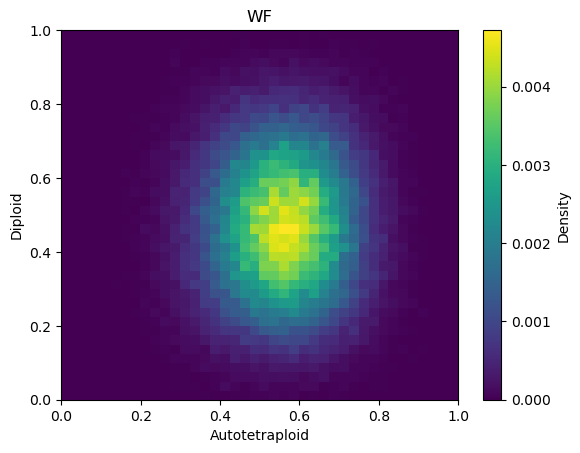

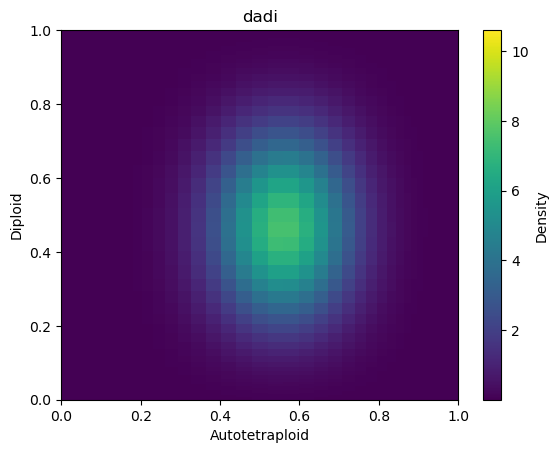

In [24]:
# COMPARE JOINT PHI

# WF MODEL
# let's plot the joint distribution 
# first, we create a 2D histogram
auto_edges = np.linspace(0, 1, 41)
dip_edges = np.linspace(0, 1, 41)
hist, xedges, yedges = np.histogram2d(x=auto_freqs.flatten(), y=dip_freqs.flatten(), bins=[auto_edges, dip_edges])

# remove lost or fixed alleles
hist[0, 0] = 0
hist[-1, -1] = 0

# normalize to a probability density
hist_density = hist / hist.sum()

# Transpose due to row/column orientation
plt.imshow(hist_density.T, cmap='viridis', origin='lower', extent=[0, 1, 0, 1], aspect='auto')
plt.colorbar(label='Density')
plt.xlabel('Autotetraploid')
plt.ylabel('Diploid')
plt.title('WF')
plt.show()


# DIFFUSION MODEL
# let's visualize the joint density

# because the grid is not uniform, plotting phi requires specifying bin edges
# here, we create those edges
# because the grid is the same for both populations, we only need to calculate these once
mid = 0.5 * (xx[1:] + xx[:-1])
first = xx[0] - (mid[0] - xx[0])
last = xx[-1] + (xx[-1] - mid[-1])
edges = np.concatenate([[first], mid, [last]])

plt.pcolormesh(edges, edges, phi, cmap='viridis', shading='auto')
plt.colorbar(label='Density')
plt.xlabel('Autotetraploid')
plt.ylabel('Diploid')
plt.title('dadi')
plt.show()


WF MODEL
Autotetraploid Results Summary
Retained density for autotetraploids is: 1.0
Mean final allele frequency for autotetraploids: 0.5576708575000001
Variance of final allele frequency for autotetraploids: 0.014047690423339691


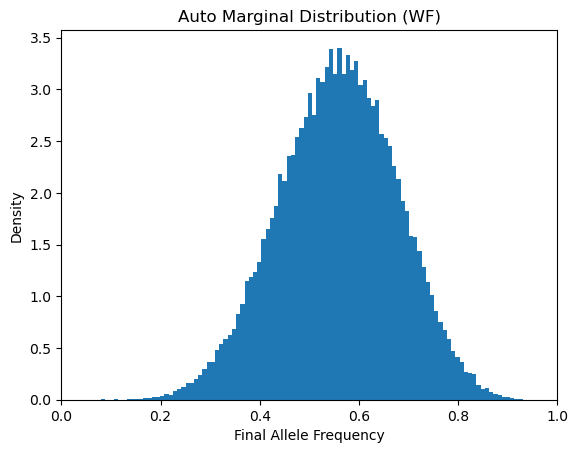

Diploid Results Summary
Retained density for diploids is: 0.99994
Mean final allele frequency for diploids: 0.4716913614816889
Variance of final allele frequency for diploids: 0.028193470891233956


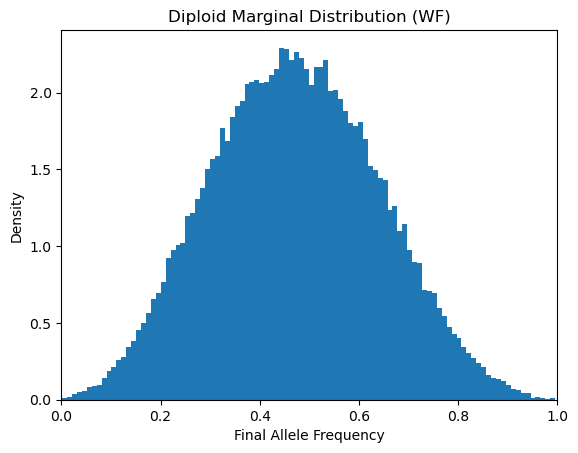

Autotetraploid Results Summary
Mean: 0.5569980617684275
Variance: 0.014073775825474644


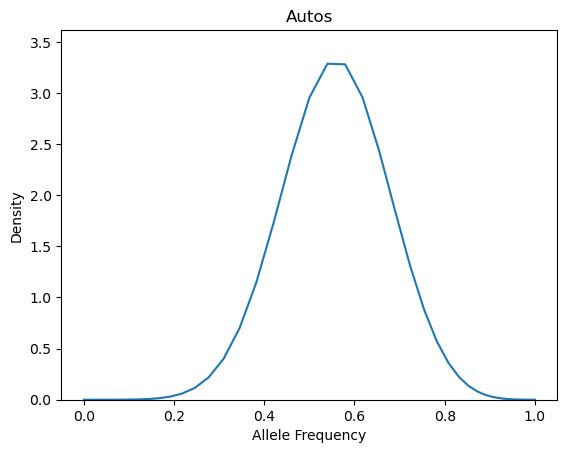

Diploid Results Summary
Mean: 0.47201432963000606
Variance: 0.028045366517413073


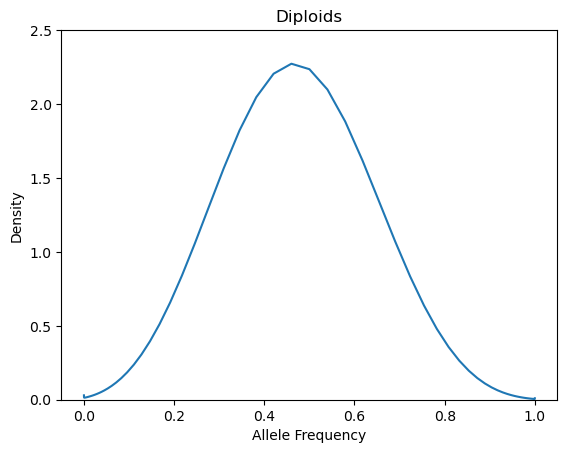

In [25]:
# COMPARE MARGINALIZED PHI

# WF MODEL
# Compute and print retained density, means, and variances of each model
# Autos first
print("WF MODEL")
print("Autotetraploid Results Summary")
print(f"Retained density for autotetraploids is: {auto_polymorphic.size/auto_freqs.size}")
print(f"Mean final allele frequency for autotetraploids: {np.mean(auto_polymorphic)}")
print(f"Variance of final allele frequency for autotetraploids: {np.var(auto_polymorphic)}")
# Plot histogram of final allele frequencies
plt.hist(auto_polymorphic, bins = 100, density = True)
plt.xlabel('Final Allele Frequency')
plt.ylabel('Density')
plt.title('Auto Marginal Distribution (WF)')
plt.xlim(0, 1)
plt.show()

# And diploids too
print("Diploid Results Summary")
print(f"Retained density for diploids is: {dip_polymorphic.size/dip_freqs.size}")
print(f"Mean final allele frequency for diploids: {np.mean(dip_polymorphic)}")
print(f"Variance of final allele frequency for diploids: {np.var(dip_polymorphic)}")
# Plot histogram of final allele frequencies
plt.hist(dip_polymorphic, bins = 100, density = True)
plt.xlabel('Final Allele Frequency')
plt.ylabel('Density')
plt.title('Diploid Marginal Distribution (WF)')
plt.xlim(0, 1)
plt.show()

# DIFFUSION MODEL
# for comparisons to the above, we will want to marginalize phi
# marginalize
auto_phi = np.sum(phi, axis=0)
# down project the marginalized phi to the polymorphic portion
auto_phi = auto_phi[1:-1]
# create compatible grid for polymorphic phi
xx = xx[1:-1]
print("Autotetraploid Results Summary")
WF.summarize_phi(auto_phi, xx, 'Autos')

# same as above, but for diploids
dip_phi = np.sum(phi, axis=1)
dip_phi = dip_phi[1:-1]

print("Diploid Results Summary")
WF.summarize_phi(dip_phi, xx, 'Diploids')



## Compare Performance of Various $\delta_j$ Implementations

Here, I test my version of the $\delta_j$ trick presented in Chang and Cooper (1970) vs. Ryan's implementation vs. no use of the trick at all. 

In [26]:
# The negative points in phi seem problematic because phi should be a joint probability density
# The use of Chang and Cooper's \delta_j trick should theoretically fix this problem

# This is, in fact, not the case here because of the singular boundaries which create difficulties 
# with using the \delta_j trick

# Still, let's test my \delta_j implementation against Ryan's

# for these tests on the usage of delta_j, it is likely better to initialize the grid and phi used in dadi
xx = dadi.Numerics.default_grid(pts=101)

# Note that Chang and Cooper's \delta_j trick does not address the above example's negativity
# Now, let's see if it has something to do with the autotetraploids or not
phi1 = dadi.PhiManip.phi_1D(xx)
phi1 = dadi.PhiManip.phi_1D_to_2D(xx, phi1)
phi1 = dadi.Integration._two_pops_const_params(phi1, xx, T=1, m12=0, m21=.1, gamma1=-2, gamma2=4, nomut1=True, nomut2=True)
print("DIPLOID W/O")
print(f"Proportion of negative entries: {np.sum(np.less(phi1, 0))/phi1.size}")
# There are a handful of negative entries, but the negative entries are far less prevalent 
# compared to the diploid-tetraploid case



phi2 = dadi.PhiManip.phi_1D(xx)
phi2 = dadi.PhiManip.phi_1D_to_2D(xx, phi2)
phi2 = poly_int._two_pops_const_params(phi2, xx, T=1, m12=0, m21=.1, gamma1=-2, gamma2_1=1, gamma2_2=2, 
                                       gamma2_3=3, gamma2_4=4, nomut1=True, nomut2=True)
print("DIP-AUTO W/O")
print(f"Proportion of negative entries: {np.sum(np.less(phi2, 0))/phi2.size}")

phi3 = dadi.PhiManip.phi_1D(xx)
phi3 = dadi.PhiManip.phi_1D_to_2D(xx, phi3)
phi3 = poly_int_olddelj._two_pops_const_params(phi3, xx, T=1, m12=0, m21=.1, gamma1=-2, gamma2_1=1, gamma2_2=2, 
                                                gamma2_3=3, gamma2_4=4, nomut1=True, nomut2=True)
print("DIP-AUTO W/ RYAN'S")
print(f"Proportion of negative entries: {np.sum(np.less(phi3, 0))/phi3.size}")

phi4 = dadi.PhiManip.phi_1D(xx)
phi4 = dadi.PhiManip.phi_1D_to_2D(xx, phi4)
# Perhaps a better illustration of this problem is this one
phi4 = poly_int_delj._two_pops_const_params(phi4, xx, T=1, m12=0, m21=.1, gamma1=-2, gamma2_1=1, gamma2_2=2, 
                                            gamma2_3=3, gamma2_4=4, nomut1=True, nomut2=True)
print("DIP_AUTO W/ SAM'S")
print(f"Proportion of negative entries: {np.sum(np.less(phi4, 0))/phi4.size}")

# Note: from plotting the marginalized densities, there seem to be substantial changes in the results near the boundaries
# I think the only real way to test which approach is better is to compare to a 1D case where an analytical solution exists
# So, let's do that below in the next code block


DIPLOID W/O
Proportion of negative entries: 0.013332026271934125
dt = 0.002
DIP-AUTO W/O
Proportion of negative entries: 0.013528085481815508
DIP-AUTO W/ RYAN'S
Proportion of negative entries: 0.013528085481815508
DIP_AUTO W/ SAM'S
Proportion of negative entries: 0.008822664444662289


## Mass Conservation in 2D
This is Sam playing around with how mass is conserved in the 2D populations

In [27]:
# Testing to see how mass is conserved in the polyploid integration

xx = dadi.Numerics.default_grid(pts=41)

phi = dadi.PhiManip.phi_1D(xx)

print(np.trapz(phi, xx))

phi_equil = dadi.PhiManip.phi_1D_to_2D(xx, phi)

print(np.trapz(
        np.trapz(phi_equil, xx, axis=0), 
        xx, axis=0))

# first, compare conservation for a 2 pop diploid integration
phi_dip = dadi.Integration._two_pops_const_params(phi_equil, xx, T=.1)
print(np.trapz(
        np.trapz(phi_dip, xx, axis=0), 
        xx, axis=0))

# then, do the auto-dip integration
phi = dadi.PhiManip.phi_1D(xx)
phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
phi_auto = poly_int._two_pops_const_params(phi, xx, T=.1)
print(np.trapz(
        np.trapz(phi_auto, xx, axis=0), 
        xx, axis=0))

10.06348241702822
9.563399936220016
16.738128275402445
dt = 0.004
16.434487533348243
